start by including libraries

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

Then, we include the data sets


In [46]:
baseline = pd.read_csv('patient_baseline.csv', delimiter='\t')
longitudinal = pd.read_csv('patient_longitudinal.csv', delimiter = '\t')
treatment = pd.read_csv('patient_treatment.csv', delimiter = '\t')

Time Series: turn them to time series; also find if there are missing values and duplicates 

In [47]:
longitudinal['visit_date'] = pd.to_datetime(longitudinal['visit_date'], format='%Y-%m-%d')
print(longitudinal.isnull().sum())
print(longitudinal[longitudinal.duplicated(keep=False)])


patient_id       0
visit_date       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64
Empty DataFrame
Columns: [patient_id, visit_date, bp_systolic, heart_rate, adverse_event, age, sex, bmi, smoking, diabetes]
Index: []


There are no missing values nor duplicates, thus we continue as is.

Time series: Analyze blood pressure trends using mean aggregation, 3 month moving averages, and exponential weighted averages

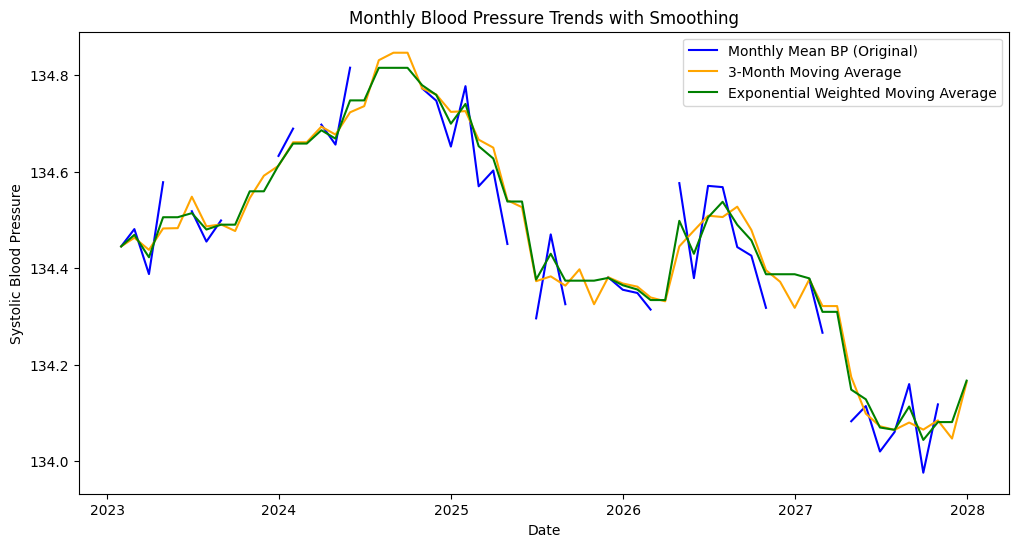

In [48]:
longitudinal.set_index('visit_date', inplace=True)
#mean aggregation
monthly_bp = longitudinal['bp_systolic'].resample('ME').mean()
#three month moving averages
monthly_bp_smoothed = monthly_bp.rolling(window=3, min_periods=1).mean()
monthly_bp_smoothed = monthly_bp_smoothed.interpolate()
#stabilize
monthly_bp_ewm = monthly_bp.ewm(span=3, min_periods=1).mean()
#plot the graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_bp, label='Monthly Mean BP (Original)', color='blue')
plt.plot(monthly_bp_smoothed, label='3-Month Moving Average', color='orange')
plt.plot(monthly_bp_ewm, label='Exponential Weighted Moving Average', color='green')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure')
plt.title('Monthly Blood Pressure Trends with Smoothing')
plt.legend()
plt.show()

We can see that monthly is the least stable of the three while 3months margin undermines the instability of the pressure. The EWM function complements the two and presents the best solution.

Statistical modelling: Analyze factors affecting baseline blood pressure:


                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.65e-100
Time:                        00:02:02   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

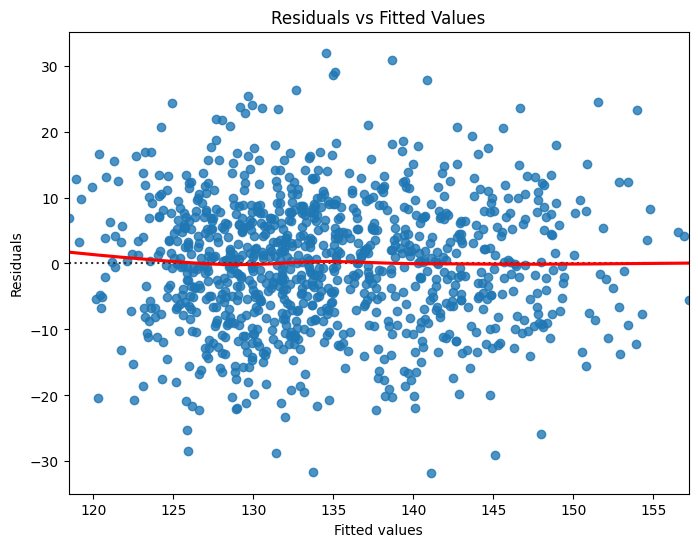

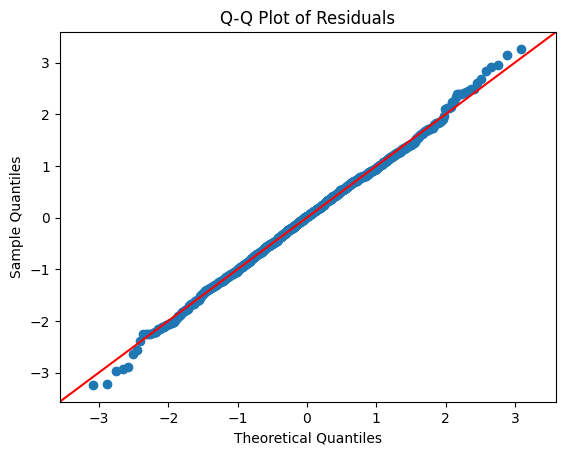

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        00:02:03   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

In [49]:
# set predictors and target variables
X = baseline[['age', 'bmi', 'smoking', 'diabetes']]
X = sm.add_constant(X)  # Adds a constant term for the intercept
y = baseline['bp_systolic']
#set the model
model = sm.OLS(y, X).fit()
#print the summary
print(model.summary())
#plot according to summary
plt.figure(figsize=(8, 6))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()
#Adapted QQ plot
sm.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()
#Robust using HC3
model_robust = sm.OLS(y, X).fit(cov_type='HC3')
print(model_robust.summary())

We can see that the F statistic of 150.2 and R^2 = 0.376 meant that least regressions is not a good model to use to predict the data, and HC3 didn't help much as well. However, when we look at the distribution of the QQ plot, the residuals align closely to 45 degrees and the highest density in the center, meaning that it might follow a normal distribution instead.

Statistical Modelling tasks: Model Treatment Effectiveness

           Odds Ratio      2.5%     97.5%
const        0.281360  0.072687  1.089105
age          1.002744  0.993428  1.012147
bmi          1.030101  1.001936  1.059058
smoking      0.677929  0.456134  1.007574
diabetes     0.613448  0.438726  0.857752
adherence    1.129833  0.305350  4.180529
Null Deviance: 1331.9768185036037
Residual Deviance: 1312.832088524959


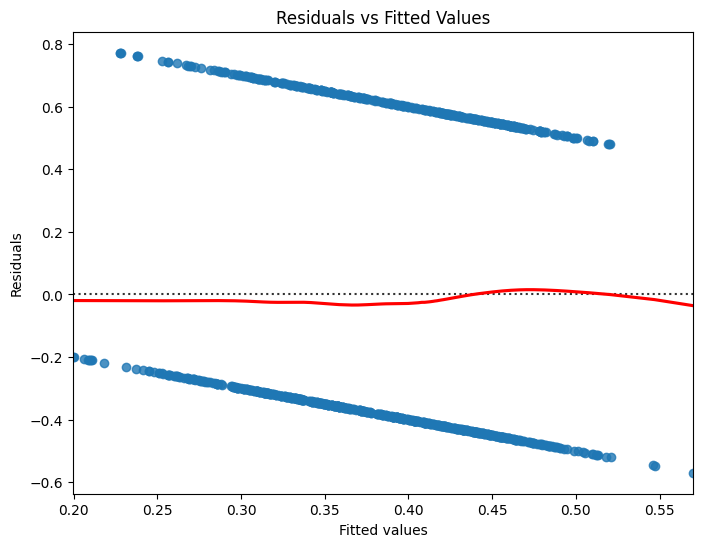

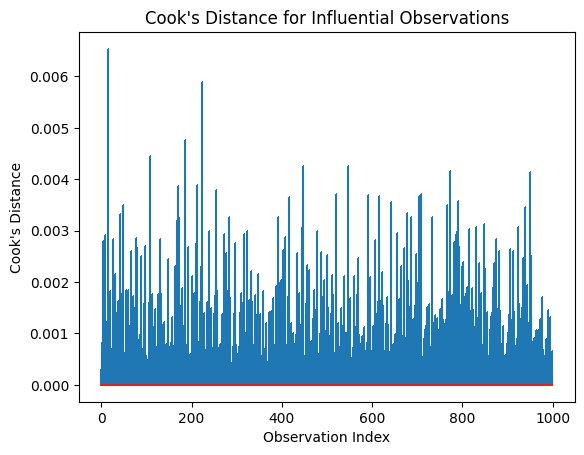

In [50]:
#setting up predictors and results
X = treatment[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
X = sm.add_constant(X)
y = treatment['outcome']
#setting up the model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
#adding odds ratio
odds_ratios = np.exp(model.params)
#setting confidence intervals
conf = model.conf_int()
conf.columns = ['2.5%', '97.5%']
#creating boundaries
odds_ratios_conf = np.exp(conf)
odds_ratios_summary = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    '2.5%': odds_ratios_conf['2.5%'],
    '97.5%': odds_ratios_conf['97.5%']
})
print(odds_ratios_summary)
print(f"Null Deviance: {model.null_deviance}")
print(f"Residual Deviance: {model.deviance}")
#creating plot
plt.figure(figsize=(8, 6))
sns.residplot(x=model.fittedvalues, y=model.resid_response, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()
#get influence
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
#plotting the influence
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Influential Observations")
plt.show()

We can see that there are major differences between the two. Null Residuals fitted worse than the fitted values.